# Восстановление золота из руды

## Подготовка данных

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

#### Рассчитаем эффективность обогащения на стадии флотации:

In [3]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']
recovery =  100*C*(F-T)/(F*(C-T))

In [4]:
mae = mean_absolute_error(recovery, train['rougher.output.recovery'])
print('MAE = ', mae)

MAE =  1.1498046842860452e-14


Средняя абсолютная погрешность минимальна и практически равна нулю, следовательно эффективность обогащения рассчитана верно.

#### Проанализируем признаки недоступные в тестовой выборке:

In [5]:
columns_not_test = np.setdiff1d(full.columns, test.columns)

In [6]:
train[columns_not_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_au                         14149 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_au                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


В тестовой выборке отсутствуют параметры продукта и отвальных хвостов после каждого из этапов технологического процесса,а также некоторые расчетные характеристики, пока процесс не закончился измерить их невозможно. Однако все остальные параметры есть, а также характеристики изначальной смеси золотоносной руды.

#### Выполним предобработку:

Изменим тип данных для даты:

In [7]:
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format = '%Y-%m-%d %H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format = '%Y-%m-%d %H:%M:%S')

Соседние параметры часто похожи, поэтому заполним пропуски в данных значениями соответствующими ближайшими по времени:

In [8]:
test_data = test.fillna(method='ffill')
train_data = train.fillna(method='ffill')
full_data = full.fillna(method='ffill')

Существуют значения, с нулевыми концентрациями:

In [9]:
full_data[full_data['final.output.concentrate_au'] == 0].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
644,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,...,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808
1193,2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,...,11.979352,-453.431061,12.003445,-450.179844,11.982937,-449.856468,9.927727,-450.521700,19.971682,-500.685521
1194,2016-03-11 11:00:00,0.0,0.0,0.0,0.0,0.0,10.436792,1.207636,17.800392,2.747294,...,12.034636,-446.590944,12.130405,-449.684812,11.844983,-450.881424,9.916784,-449.542871,20.004767,-500.137068
1195,2016-03-11 12:00:00,0.0,0.0,0.0,0.0,0.0,10.637073,1.405778,17.195897,2.791440,...,12.016716,-496.613149,12.055535,-496.908551,12.091144,-496.404140,9.976074,-496.783155,19.921634,-500.769011
1196,2016-03-11 13:00:00,0.0,0.0,0.0,0.0,0.0,10.530320,1.461550,17.556860,2.682127,...,11.993898,-500.427824,12.083824,-500.162537,12.078809,-499.903743,10.075259,-499.540325,20.039788,-499.932405


Удалим такие строки c нулевыми концентрациями а также близкими к нулю концентрациями так как возможно произошла ошибка при измерениях:

In [10]:
full_data.loc[full_data['rougher.output.concentrate_au'] < 0.1] = np.NaN
full_data.loc[full_data['primary_cleaner.output.concentrate_au'] < 0.1] = np.NaN
train_data.loc[full_data['rougher.output.concentrate_au'] < 0.1] = np.NaN
train_data.loc[full_data['primary_cleaner.output.concentrate_au'] < 0.1] = np.NaN
full_data.loc[full_data['final.output.concentrate_au'] < 0.1] = np.NaN
train_data.loc[train_data['final.output.concentrate_au'] < 0.1] = np.NaN
full_data.loc[full_data['rougher.output.recovery'] < 0.1] = np.NaN
train_data.loc[train_data['rougher.output.recovery'] < 0.1] = np.NaN

full_data.dropna(subset=['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au',
                    'final.output.concentrate_au', 'rougher.output.recovery', 'final.output.recovery'], inplace=True)
train_data.dropna(subset=['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au',
                    'final.output.concentrate_au', 'rougher.output.recovery', 'final.output.recovery'], inplace=True)

## Анализ данных

#### Исследуем изменение концентрации металлов на каждом этапе:

Оценивать будем изменение среднего значения:

In [11]:
concentrate_ag = full_data[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
                       'final.output.concentrate_ag']].mean()
concentrate_pb = full_data[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
                       'final.output.concentrate_pb']].mean()
concentrate_au = full_data[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
                       'final.output.concentrate_au']].mean()

Text(0.5, 0, 'Стадия')

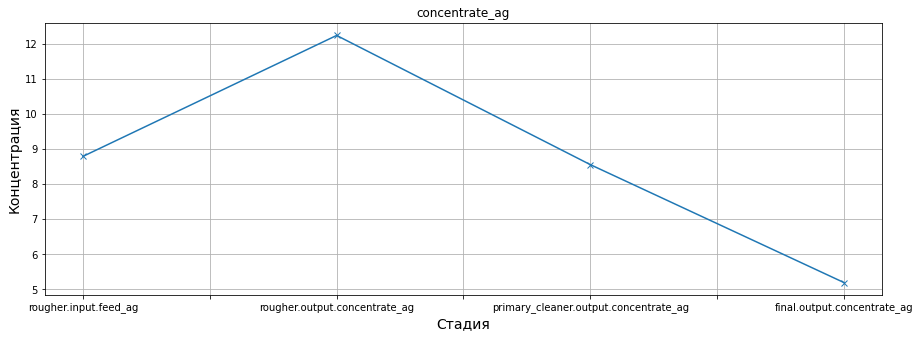

In [12]:
concentrate_ag.plot(title='concentrate_ag', style='x-', grid=True, figsize=(15, 5))
plt.ylabel('Концентрация', fontsize=14)
plt.xlabel('Стадия', fontsize=14)

Text(0.5, 0, 'Стадия')

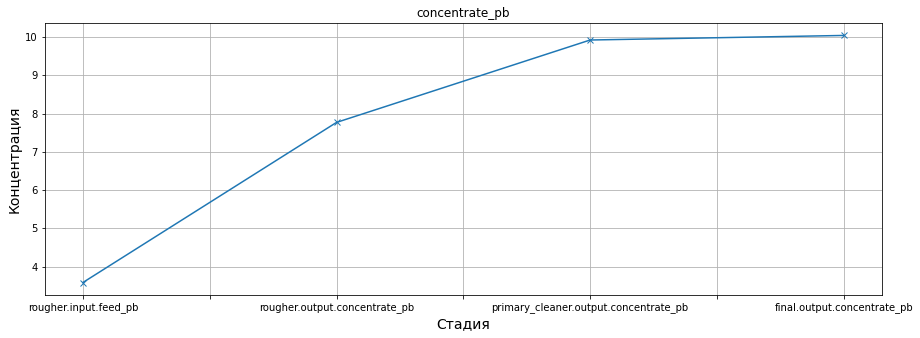

In [13]:
concentrate_pb.plot(title='concentrate_pb', style='x-', grid=True, figsize=(15, 5))
plt.ylabel('Концентрация', fontsize=14)
plt.xlabel('Стадия', fontsize=14)

Text(0.5, 0, 'Стадия')

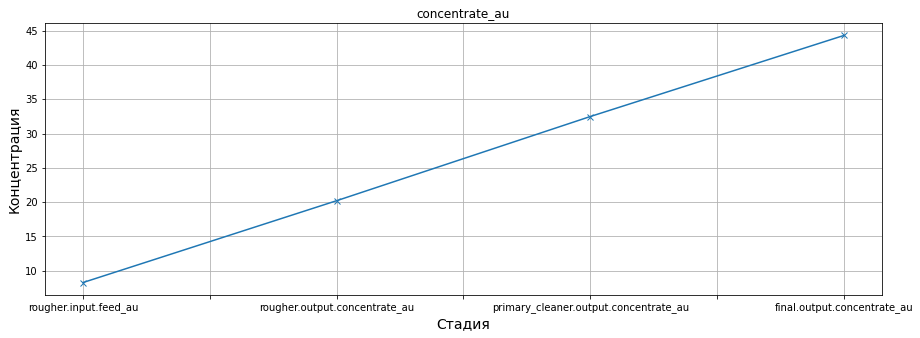

In [14]:
concentrate_au.plot(title='concentrate_au', style='x-', grid=True, figsize=(15, 5))
plt.ylabel('Концентрация', fontsize=14)
plt.xlabel('Стадия', fontsize=14)

Концентрация серебра падает, а золота растет на каждом этапе очистки, концентрация свинца незначительно растет.

#### Проанализируем распределения размеров гранул на обучающей и тестовой выборках:

<AxesSubplot:>

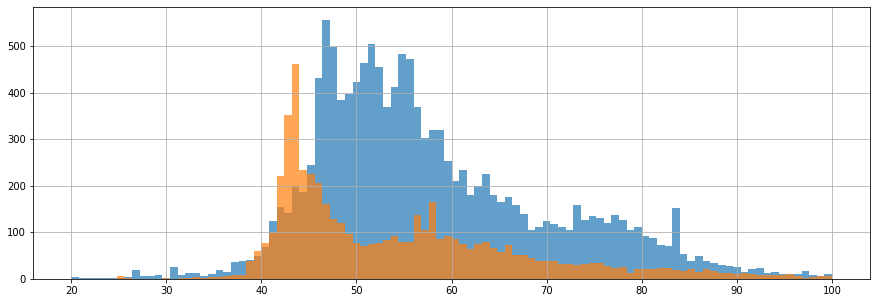

In [15]:
train_data['rougher.input.feed_size'].hist(bins=100, figsize=(15, 5), alpha = 0.7, range=(20, 100))
test_data['rougher.input.feed_size'].hist(bins=100, figsize=(15, 5), alpha = 0.7, range=(20, 100))

In [16]:
train_data['rougher.input.feed_size'].describe()

count    13794.000000
mean        60.260355
std         23.085980
min          9.659576
25%         48.989406
50%         55.335999
75%         65.967786
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [17]:
test_data['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

Распределения размеров гранул сырья на обучающей и тестовой выборках сильно не отличаются друг от друга. Средние значения и стандартные отклонения сопоставимы с друг другом, а гистограммы имеют схожий вид.

#### Исследуем суммарные концентрации:

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [18]:
concentrate = pd.DataFrame()
concentrate['input_concentrate_sum'] = full_data[['rougher.input.feed_ag', 'rougher.input.feed_pb',
                                    'rougher.input.feed_sol', 'rougher.input.feed_au']].sum(axis=1)
concentrate['rougher_concentrate_sum'] = full_data[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].sum(axis=1)
concentrate['final_concentrate_sum'] = full_data[['final.output.concentrate_ag', 'final.output.concentrate_pb',
                                    'final.output.concentrate_sol', 'final.output.concentrate_au']].sum(axis=1)

In [19]:
concentrate.describe()

,input_concentrate_sum,rougher_concentrate_sum,final_concentrate_sum
count,18724.000000,18724.000000,18724.000000
mean,57.351244,69.633621,69.035878
std,7.089665,7.651108,5.458440
min,8.072476,2.016647,1.976540
25%,53.552566,66.390557,67.946259
50%,57.601655,70.345534,69.609421
75%,61.956569,74.460576,71.388476
max,76.978947,88.140119,80.210644


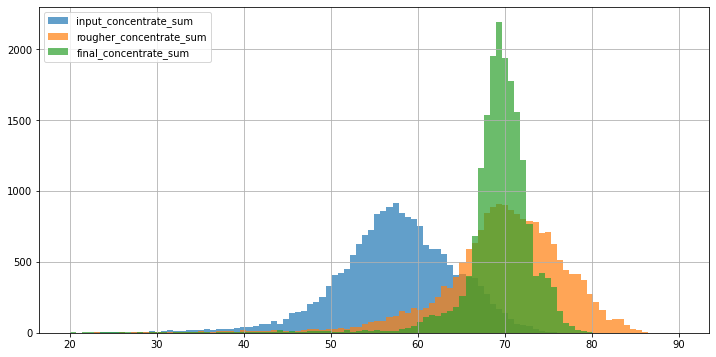

In [20]:
concentrate['input_concentrate_sum'].hist(bins=100, figsize=(12, 6), alpha = 0.7, range=(20, 90), label='input_concentrate_sum')
concentrate['rougher_concentrate_sum'].hist(bins=100, figsize=(12, 6), alpha = 0.7, range=(20, 90), label='rougher_concentrate_sum')
concentrate['final_concentrate_sum'].hist(bins=100, figsize=(12, 6), alpha = 0.7, range=(20, 90), label='final_concentrate_sum')
plt.legend(loc='upper left')

В данных были аномалии, а именно нулевые концентрации, данные строки были удалены в начале при предобработке данных. При сравнении гистограмм хорошо видно что среднее значение, вокруг которого распределена концентрация металлов смещается вправо, т.е. увеличивается, а на последнем этапе очистки уменьшается разброс значений.

## Модель

#### Функция для вычисления метрики sMAPE

In [21]:
def s_mape(target, predicted):
    predicted_rougher_recovery = predicted[:,0]
    predicted_final_recovery = predicted[:,1]
    target_rougher_recovery = np.array(target)[:,0]
    target_final_recovery = np.array(target)[:,1]
        
    sMAPE_rougher = abs(target_rougher_recovery - predicted_rougher_recovery) / ((abs(target_rougher_recovery) + abs(predicted_rougher_recovery))/2)
    sMAPE_rougher = 100 * sMAPE_rougher.sum() / len(target_rougher_recovery)
    
    sMAPE_final = abs(target_final_recovery - predicted_final_recovery) / ((abs(target_final_recovery) + abs(predicted_final_recovery))/2)
    sMAPE_final = 100 * sMAPE_final.sum() / len(target_final_recovery)
    
    sMAPE = 0.25*sMAPE_rougher + sMAPE_final*0.75
    return sMAPE

### Обучение модели

Обучим разные модели и оценим их качество кросс-валидацией.

In [22]:
target = train_data[['rougher.output.recovery', 'final.output.recovery']]
features = train_data.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

### Дерево решений

Подберем оптимальные гиперпараметры:

In [23]:
def decision_tree(features, target):
    best_model = None
    best_final_score = 1000
    for i in range(1, 15):
        model = DecisionTreeRegressor(random_state=12345,
                                      max_depth=i)
        scores = cross_val_score(model, features, target, scoring = make_scorer(s_mape))
        final_score = scores.mean()
        if final_score < best_final_score:
            best_model = model
            best_final_score = final_score
    print('best_model =', best_model)
    print(f"Средняя оценка качества модели {scores.mean():.3f} % и ее стандартное отклонение {scores.std():.3f} %")
    return best_model

In [24]:
model = DecisionTreeRegressor(random_state=12345)
parametrs = { 'max_depth': range (1, 16, 1)}
grid = GridSearchCV(model,
                    parametrs,
                    scoring=make_scorer(s_mape,
                                        greater_is_better=False),
                    cv=5,
                    error_score="raise")
grid.fit(features, target)

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 16)},
             scoring=make_scorer(s_mape, greater_is_better=False))

In [25]:
print('model =', grid.best_params_)
print('best_score =', grid.best_score_)

model = {'max_depth': 12}
best_score = -4.1557007265730705


In [26]:
%%time
model_1 = decision_tree(features, target)

best_model = DecisionTreeRegressor(max_depth=12, random_state=12345)
Средняя оценка качества модели 4.254 % и ее стандартное отклонение 0.626 %
CPU times: user 42.4 s, sys: 16 ms, total: 42.4 s
Wall time: 42.4 s


### Случайный лес

Так как оптимальная величина глубины дерева уже найдена обучим случайный лес с той же величиной глубины дерева:

In [27]:
%%time
model_2 = RandomForestRegressor(random_state=12345,
                                max_depth=12,
                                n_estimators=30)
scores = cross_val_score(model_2, features, target, scoring = make_scorer(s_mape))
final_score = scores.mean()
print('model =', model_2)
print(f"Средняя оценка качества модели {scores.mean():.3f} % и ее стандартное отклонение {scores.std():.3f} %")

model = RandomForestRegressor(max_depth=12, n_estimators=30, random_state=12345)
Средняя оценка качества модели 2.512 % и ее стандартное отклонение 0.482 %
CPU times: user 1min 21s, sys: 80 ms, total: 1min 22s
Wall time: 1min 22s


 ### Выберем лучшую модель и проверим её на тестовой выборке

Лучшей моделью оказался случайный лес

In [28]:
test = test_data.drop(['date'], axis=1)

In [29]:
features_train = train_data.drop(['date'], axis=1)
features_train = features_train.drop(columns_not_test, axis=1)
features_target = train_data[['rougher.output.recovery', 'final.output.recovery']]

In [30]:
%%time
model = RandomForestRegressor(random_state=12345,
                              max_depth=12,
                              n_estimators=30)
model.fit(features_train, features_target)
test_predicted = model.predict(test)

CPU times: user 13.6 s, sys: 16 ms, total: 13.6 s
Wall time: 13.6 s


In [31]:
print(test_predicted)

[[88.31439481 71.04842966]
 [88.45613743 71.35580671]
 [88.08344539 70.16231872]
 ...
 [92.9862514  71.83345875]
 [93.63838447 72.87850647]
 [92.6335642  73.20206441]]


In [32]:
full_recovery = full[['date', 'rougher.output.recovery', 'final.output.recovery']]
target_recovery = test_data.merge(full_recovery, on='date', how = 'inner')
target_recovery = target_recovery[['rougher.output.recovery', 'final.output.recovery']]

In [33]:
S_MAPE = s_mape(target_recovery, test_predicted)
print(f"Итоговое sMAPE = {S_MAPE :.3f} %")

Итоговое sMAPE = 9.705 %
